In [2]:
import os
from bs4 import BeautifulSoup
from requests import get
import pandas as pd
import numpy as np
import time
import random
import itertools
import json # library to handle JSON files
import folium # library for plot map
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import requests


In [3]:
with open('NSW_suburb.json') as json_data:
    NSW_data = json.load(json_data)
NSW_data_feature = NSW_data['features']
print("the len of NSW suburb data is ", len(NSW_data_feature) )

the len of NSW suburb data is  4592


In [3]:
#since the previous suburb csv file does not have a header, this block will add a header to it. 
SYDsuburb = pd.read_csv("suburb.csv")
header_names = ['suburb']
SYDsuburb = pd.read_csv('suburb.csv', header = None, skiprows = 1, names = header_names)
SYDsuburb.to_csv = ('SYDsuburb.csv')

In [4]:
#In the research proposal, I thought postal code is not necessary for this project. However, in order to get the population data, the website domain.com need both the suburb name and postal code. Instead of web scraping, I just download a file that contants suburb's postal codes, latitude and longitude. 
postcode = pd.read_csv("Australian_Post_Codes_Lat_Lon.csv")

In [5]:
#instead of running through all the post code around Australia, I just need to compare the NSW suburb's post code and Sydney suburb's post code
NSWPC = postcode[postcode["state"] == 'NSW']
NSWPC.to_csv('NSWPC.csv', index = False)
NSWPC.head()

,postcode,suburb,state,dc,type,lat,lon
145,1001,SYDNEY,NSW,EAST SUBS MC,LVR,-33.794883,151.268071
146,1002,SYDNEY,NSW,EAST SUBS MC,LVR,-33.794883,151.268071
147,1003,SYDNEY,NSW,EAST SUBS MC,LVR,-33.794883,151.268071
148,1004,SYDNEY,NSW,EAST SUBS MC,LVR,-33.794883,151.268071
149,1005,SYDNEY,NSW,GPO BOX CENTRE,LVR,-33.794883,151.268071


In [6]:
#From the type column. we have LVR which stands for large volumn receiver, null which is place holder, and delivery area. In this case, we only need the postcode for delivery area. 
NSWPC = NSWPC[NSWPC["type"].str.contains ("Delivery Area")]
keep_col = ['postcode','suburb','lat','lon']
NSWPC2 = NSWPC[keep_col]
NSWPC2.to_csv("NSWPC2.csv", index =False)



In [7]:
#I found out that all the suburb name in NSWPC2 is are uppercase, however, all the suburb name in SYDsuburb are in title form. Therefore, I'm going to change both of them into uppercase
SYDsuburb = pd.read_csv("suburb.csv", index_col = 0)
SYDsuburb['suburb'] = SYDsuburb['suburb'].str.upper()
SYDsuburb.head()

,suburb
0,
1,== A ==
2,ABBOTSBURY
3,ABBOTSFORD
4,ACACIA GARDENS
5,AGNES BANKS


In [8]:
SYDPC =  pd.merge(SYDsuburb, NSWPC2, left_on = 'suburb', right_on = 'suburb', how = 'outer')

In [9]:
SYDPC.to_csv("SYDPC.csv", index=False)

In [10]:
#By manually check the output, I found out that all data for non-Sydney suburb has been paste after the data for Sydney suburb, which is after row no.787. Therefore, I'm going to drop all non-Sydney suburb.
SYDPC = pd.read_csv("SYDPC.csv", skipinitialspace= True, nrows= 788)
SYDPC.tail()

,suburb,postcode,lat,lon
783,YARRAWARRAH,2233.0,-34.058462,151.032790
784,YENNORA,2161.0,-33.860889,150.969356
785,YOWIE BAY,2228.0,-34.049866,151.104325
786,== Z ==,NaN,NaN,NaN
787,ZETLAND,2017.0,-33.909938,151.206234


In [11]:
#Furthermore, I found out that not all Sydney suburb have post code, latitude and longitude information. However, those info is vital for further research. As a result, I'm going to drop all rows that does not contains latitude information since if the row doesn't have latitude info also lack of post code and longitude info. 
SYDPC = SYDPC[pd.notnull(SYDPC['lat'])]
SYDPC.to_csv("SYDPC3.csv", index= False)

In [2]:
#Since we have all the post code and suburb info for Sydney, the next step is to get the population for each suburb. This time I'm going to use beautifulsoup to scrap data from domain.com
headers = ({'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/65.0.3325.181 Safari/537.36'})
domain = "https://www.domain.com.au/suburb-profile/ashfield-nsw-2131"
response = get(domain, headers = headers)
print(response)

<Response [200]>


In [3]:
soup = BeautifulSoup(response.text, 'html.parser')
house_containers = soup.find_all('div',class_ = "suburb-profile__row")
demography = house_containers[0].find_all('div', class_="css-54bw0x")[0].find_all('div', class_="css-jkrtif")
demography

[]

In [4]:
def getDemography(suburb_names, postcode_list, state='NSW'):
    Demography_list = []
    for suburb, postcode in zip(suburb_names, postcode_list):
        print(suburb)
        suburb = suburb.replace(' ','-')
        headers = ({'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/65.0.3325.181 Safari/537.36'})
        url = 'https://www.domain.com.au/suburb-profile/{}-nsw-{}'.format(suburb, postcode)
        response = get(url, headers = headers)
        soup = BeautifulSoup(response.text, 'html.parser')
        info_containers = soup.find_all('div', class_ = "suburb-profile__row")
        try:
            if info_containers != []:

                demography = info_containers[0].find_all('div', class_="css-jkrtif")[0].find_all('div', class_="css-54bw0x")

                if demography != []:

                    population = demography[0].text
                    population = population.replace(',', '')
                    age = demography[1].text

                else:     
                    # sometime there will be a promotion section on the result site, hence demography info locates in different section.
                    demography = info_containers[1].find_all('div', class_="css-jkrtif")[0].find_all('div', class_="css-54bw0x")
                    
                    if demography != []:
                        population = demography[0].text
                        population = population.replace(',', '')
                        age = demography[1].text
                    
                    else:
                        # sometimes there will be no infomation.
                        population = "NA"
                        age = "NA"

            else:
                # sometimes there is no infomation
                population = "NA"
                age = "NA" 
        
        except:
            pass

        # return only relevant information for suburb
        Demography_list.append([(
            suburb, 
            postcode, 
            population, 
            age)])
        
        # Wait a given time bewteen 5 to 15 seconds for scraping the next website to mimic a humanbeing search.
        time.sleep(random.randint(5,15))     
    
    return(Demography_list)


In [5]:
#I found out that the data type can affect the result of web scrape. So I manually change all the data type to str instead of float. It can also be done by using pd.read_csv('SYDPC3.csv', dtype = str)
SYDPC = pd.read_csv('SYDPC3.csv')
SYDPC.head()

,suburb,postcode,lat,lon
0,ABBOTSBURY,2176,-33.877538,150.867768
1,ABBOTSFORD,2046,-33.852469,151.129453
2,ACACIA GARDENS,2763,-33.730077,150.906502
3,AGNES BANKS,2753,-33.618877,150.707372
4,AIRDS,2560,-34.084468,150.829041


In [6]:
sydney_demography = getDemography(suburb_names=SYDPC['suburb'][1:64].str.lower(), postcode_list=SYDPC['postcode'][1:64])

abbotsford
acacia gardens
agnes banks
airds
alexandria
alfords point
allambie heights
allawah
ambarvale
annandale
annangrove
arcadia
arncliffe
arndell park
artarmon
ashbury
ashcroft
ashfield
asquith
auburn
austral
avalon beach
badgerys creek
balgowlah
balgowlah heights
balmain
balmain east
bangor
banksia
banksmeadow
bankstown
bankstown aerodrome
barden ridge
bardwell park
bardwell valley
bass hill
baulkham hills
bayview
beacon hill
beaconsfield
beaumont hills
beecroft
belfield
bella vista
bellevue hill
belmore
belrose
berala
berkshire park
berowra
berowra heights
berowra waters
berrilee
beverley park
beverly hills
bexley
bexley north
bickley vale
bidwill
birchgrove
birrong
blackett
blacktown


In [7]:

sydney_demography2 = getDemography(suburb_names=SYDPC['suburb'][65:100].str.lower(), postcode_list=SYDPC['postcode'][65:100])

sydney_demography3 = getDemography(suburb_names=SYDPC['suburb'][100:137].str.lower(), postcode_list=SYDPC['postcode'][100:137])

sydney_demography4 = getDemography(suburb_names=SYDPC['suburb'][137:183].str.lower(), postcode_list=SYDPC['postcode'][137:183])

sydney_demography5 = getDemography(suburb_names=SYDPC['suburb'][183:351].str.lower(), postcode_list=SYDPC['postcode'][183:351])

sydney_demography6 = getDemography(suburb_names=SYDPC['suburb'][351:668].str.lower(), postcode_list=SYDPC['postcode'][351:668])

blairmount
blakehurst
bligh park
bondi
bondi beach
bondi junction
bonnet bay
bonnyrigg
bonnyrigg heights
bossley park
botany
bow bowing
box hill
bradbury
breakfast point
bringelly
bronte
brooklyn
brookvale
bundeena
burraneer
burwood
burwood heights
busby
cabarita
cabramatta
cabramatta west
cambridge gardens
cambridge park
camden
camden south
camellia
cammeray
campbelltown
camperdown
campsie
canada bay
canley heights
canley vale
canoelands
canterbury
caringbah
carlingford
carlton
carramar
carss park
cartwright
castle cove
castle hill
castlecrag
castlereagh
casula
catherine field
cattai
cawdor
cecil hills
cecil park
chatswood
chatswood west
cheltenham
cherrybrook
chester hill
chifley
chippendale
chipping norton
chiswick
chullora
church point
claremont meadows
clarendon
clareville
claymore
clemton park
clontarf
clovelly
clyde
coasters retreat
cobbitty
colebee
collaroy
colyton
como
concord
concord west
condell park
connells point
coogee
cornwallis
cottage point
cowan
cranebrook
cremorne
cr

In [8]:
# Once finish, concatenate all lists as one
sydney_demography_all = sydney_demography + sydney_demography2 + sydney_demography3 + sydney_demography4 + sydney_demography5 + sydney_demography6

# Convert the list into a dataframe
sydney_demography_list = pd.DataFrame([item for sydney_demography_all in sydney_demography_all for item in sydney_demography_all])
sydney_demography_list.columns = ['suburb',
                                 'postcode',
                                 'population',
                                 'age']
sydney_demography_list.head()

,suburb,postcode,population,age
0,abbotsford,2046,5366,40 to 59
1,acacia-gardens,2763,3786,20 to 39
2,agnes-banks,2753,919,40 to 59
3,airds,2560,2939,5 to 19
4,alexandria,2015,8266,20 to 39


In [9]:
sydney_demography_list.to_csv('sydney_demography_list.csv',index = False)

In [10]:
covid19_loc = pd.read_csv('covid-19-cases-by-notification-date-and-postcode-local-health-district-and-local-government-area.csv', dtype= object)
covid19_loc.head()

,notification_date,postcode,lhd_2010_code,lhd_2010_name,lga_code19,lga_name19
0,2020-01-25,2134,X700,Sydney,11300,Burwood (A)
1,2020-01-25,2121,X760,Northern Sydney,16260,Parramatta (C)
2,2020-01-25,2071,X760,Northern Sydney,14500,Ku-ring-gai (A)
3,2020-01-27,2033,X720,South Eastern Sydney,16550,Randwick (C)
4,2020-03-01,2163,X710,South Western Sydney,12850,Fairfield (C)


In [11]:
cod_loc_fq = covid19_loc.loc[:,'postcode'].value_counts()

In [12]:
cod_loc_fq.head()

2026    113
2747     50
2145     42
2088     41
2022     37
Name: postcode, dtype: int64

In [17]:
cod_loc_fq.astype(object)

2026    113
2747     50
2145     42
2088     41
2022     37
       ... 
2333      1
2063      1
2231      1
2630      1
2550      1
Name: postcode, Length: 398, dtype: object

In [19]:
cod_loc_fq.to_csv('cod_loc_fq.csv')

In [25]:
df_locfq = pd.read_csv('cod_loc_fq.csv', names = ['postcode','total_patient'], dtype = object)

In [26]:
df_locfq.head()

,postcode,total_patient
0,2026,113
1,2747,50
2,2145,42
3,2088,41
4,2022,37


In [27]:
covid19_loc = covid19_loc[covid19_loc['postcode'].notna()]

In [82]:
SYDPC4 = pd.read_csv('SYDPC3.csv', dtype = object)

In [83]:
SYDPC4 = SYDPC4.merge(df_locfq, on = 'postcode', how = 'left')
SYDPC4.tail(20)

,suburb,postcode,lat,lon,total_patient
647,WINDSOR DOWNS,2756,-33.667695,150.803079,12
648,WINSTON HILLS,2153,-33.776054,150.987795,15
649,WISEMANS FERRY,2775,-33.408879,150.980048,NaN
650,WOLLI CREEK,2205,-33.930744,151.155272,8
651,WOLLSTONECRAFT,2065,-33.828158,151.196621,22
652,WOODBINE,2560,-34.049892,150.818872,19
653,WOODCROFT,2767,-33.754986,150.879666,11
654,WOODPARK,2164,-33.84063,150.961859,4
655,WOOLLAHRA,2025,-33.885795,151.24413,16
656,WOOLLOOMOOLOO,2011,-33.869283,151.220412,30


In [91]:
SYDPC4.to_csv('SYDPC4.csv', index=False)

In [76]:
SDL = pd.read_csv('sydney_demography_list.csv')
sydney_demography_list2 = SDL.drop(["suburb"], axis = 1)
sydney_demography_list2 = SDL.drop(["postcode"], axis = 1)
sydney_demography_list2.to_csv('sydney_demography_list2.csv', index=False)

In [77]:
SDL2 = pd.read_csv('sydney_demography_list2.csv')

In [78]:
SYDPC5 = pd.read_csv('SYDPC4.csv')

In [79]:
SYDPC5.tail(20)

,suburb,postcode,lat,lon,total_patient
647,WINDSOR DOWNS,2756,-33.667695,150.803079,12.0
648,WINSTON HILLS,2153,-33.776054,150.987795,15.0
649,WISEMANS FERRY,2775,-33.408879,150.980048,NaN
650,WOLLI CREEK,2205,-33.930744,151.155272,8.0
651,WOLLSTONECRAFT,2065,-33.828158,151.196621,22.0
652,WOODBINE,2560,-34.049892,150.818872,19.0
653,WOODCROFT,2767,-33.754986,150.879666,11.0
654,WOODPARK,2164,-33.840630,150.961859,4.0
655,WOOLLAHRA,2025,-33.885795,151.244130,16.0
656,WOOLLOOMOOLOO,2011,-33.869283,151.220412,30.0


In [80]:
SYDPC5['index'] = [i for i in range(len(SYDPC5))]
SDL2['index'] = [i for i in range(len(SDL))]

In [81]:
SYDPC5 =  pd.merge(SYDPC5, SDL2, left_on = 'index', right_on = 'index', how = 'outer')

In [83]:
SYDPC5 = SYDPC5.drop(['index'], axis = 1)

In [84]:
SYDPC5.tail()

,suburb,postcode,lat,lon,total_patient,population,age
662,YARRAMUNDI,2753,-33.627259,150.672695,5.0,828.0,40 to 59
663,YARRAWARRAH,2233,-34.058462,151.032790,13.0,2726.0,40 to 59
664,YENNORA,2161,-33.860889,150.969356,8.0,1616.0,60+
665,YOWIE BAY,2228,-34.049866,151.104325,6.0,3095.0,40 to 59
666,ZETLAND,2017,-33.909938,151.206234,11.0,10071.0,20 to 39


In [8]:
cov_age = pd.read_csv('covid-19-cases-by-notification-date-and-age-range.csv')
cov_age['age_group'] = cov_age['age_group'].str.replace('AgeGroup_', '')

In [9]:
cov_age.head()

,notification_date,age_group
0,2020-03-09,10-14
1,2020-03-09,20-24
2,2020-03-09,25-29
3,2020-03-09,35-39
4,2020-03-09,35-39


In [10]:
cov_age.loc[:,'age_group'].value_counts()

70+      447
25-29    349
20-24    281
30-34    280
60-64    259
55-59    216
50-54    213
35-39    209
45-49    207
65-69    207
40-44    158
15-19     63
10-14     25
0-4       18
5-9       12
Name: age_group, dtype: int64

In [85]:
SYDPC5.loc[:,'age'].value_counts()

20 to 39    300
40 to 59    282
60+          64
5 to 19       8
Name: age, dtype: int64

In [86]:
SYDPC5.to_csv('SYDPC5.csv', index=False)

In [ ]:
#By  manually checking the file, I deleted some duplicated suburb(same name but different coordinates) and searching for population data to fill in the blank.

In [4]:
SYDPC6 = pd.read_csv('SYDPC5.csv')

In [5]:
SYDPC6['age'] = SYDPC6['age'].str.replace('40 to 59', 'mid-age')

In [6]:
SYDPC6['age'] = SYDPC6['age'].str.replace('20 to 39', 'adult')
SYDPC6['age'] = SYDPC6['age'].str.replace('60+', 'senior')
SYDPC6['age'] = SYDPC6['age'].str.replace('5 to 19', 'young')

In [ ]:
#make a map for population, patient number and age group based on existed data

In [197]:
#population map
SYD_lat = -33.865143
SYD_lon = 151.209900
population_map = folium.Map(location= [SYD_lat, SYD_lon], zoom_start=10, tiles='cartodbpositron' )
bins = list(range(0,50000,7000))
population_map.choropleth(geo_data = NSW_data, data=SYDPC6, columns=['suburb','population'],key_on = 'feature.properties.nsw_loca_2',fill_color='BuGn', 
    fill_opacity=0.7, 
    line_opacity=0.9,
    legend_name='Population by Suburb',
    bins=bins,
    reset=True)
population_map.save(os.path.join('C:/Users/user/Desktop/test', 'SYD_demography.html'))

In [226]:
#patient number map
SYD_lat = -33.865143
SYD_lon = 151.209900
population_map = folium.Map(location= [SYD_lat, SYD_lon], zoom_start=10, tiles='cartodbpositron' )
bins = [0,10,20,30,40,50,100,120]
population_map.choropleth(geo_data = NSW_data, data=SYDPC6, columns=['suburb','total_patient'],key_on = 'feature.properties.nsw_loca_2',fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.9,
    legend_name='Patient by Suburb',
    bins=bins,
    reset=True)
population_map.save(os.path.join('C:/Users/user/Desktop/test', 'SYD_demography2.html'))

In [7]:
#We need to create a new column that indicates age range for making the age map case. 
SYDPC6['AM'] = SYDPC6['age'].map({'young':9, 'adult':29,'mid-age':49,'senior+':69})

In [230]:
#age group map
SYD_lat = -33.865143
SYD_lon = 151.209900
population_map = folium.Map(location= [SYD_lat, SYD_lon], zoom_start=10, tiles='cartodbpositron' )
bins = [5,20,40,60,100]
population_map.choropleth(geo_data = NSW_data, data=SYDPC6, columns=['suburb','AM'],key_on = 'feature.properties.nsw_loca_2',fill_color='BuPu', 
    fill_opacity=0.7, 
    line_opacity=0.9,
    legend_name='Patient by Suburb',
    bins=bins,
    reset=True)
population_map.save(os.path.join('C:/Users/user/Desktop/test', 'SYD_demography3.html'))

In [8]:
SYDPC6.tail()

,suburb,postcode,lat,lon,total_patient,population,age,AM
660,YARRAMUNDI,2753,-33.627259,150.672695,5,828,mid-age,49
661,YARRAWARRAH,2233,-34.058462,151.032790,13,2726,mid-age,49
662,YENNORA,2161,-33.860889,150.969356,8,1616,senior+,69
663,YOWIE BAY,2228,-34.049866,151.104325,6,3095,mid-age,49
664,ZETLAND,2017,-33.909938,151.206234,11,10071,adult,29


In [9]:
SYDPC6.to_csv('SYDPC6.csv', index = False)

In [43]:
cov_age_fq = cov_age.loc[:,'age_group'].value_counts()
heading = ['age','frequency']
cov_age_fq.to_csv('cov_age_fq.csv')
cov_age_fq = pd.read_csv('cov_age_fq.csv', header = None, skiprows = 1, names = heading, dtype = str)
cov_age_fq.head()

,age,frequency
0,70+,447
1,25-29,349
2,20-24,281
3,30-34,280
4,60-64,259


In [47]:
cov_age_fq['age'] = cov_age_fq['age'].str.replace('70+', 'senior')
cov_age_fq['age'] = cov_age_fq['age'].str.replace('65-69', 'senior')
cov_age_fq['age'] = cov_age_fq['age'].str.replace('60-64', 'senior')
cov_age_fq.head(20)

,age,frequency
0,senior+,447
1,adult,349
2,adult,281
3,adult,280
4,senior,259
5,55-59,216
6,50-54,213
7,adult,209
8,45-49,207
9,senior,207


In [45]:
cov_age_fq['age'] = cov_age_fq['age'].str.replace('35-39', 'adult')
cov_age_fq['age'] = cov_age_fq['age'].str.replace('30-34', 'adult')
cov_age_fq['age'] = cov_age_fq['age'].str.replace('25-29', 'adult')
cov_age_fq['age'] = cov_age_fq['age'].str.replace('20-24', 'adult')
cov_age_fq['age'] = cov_age_fq['age'].str.replace('15-19', 'young')
cov_age_fq['age'] = cov_age_fq['age'].str.replace('10-14', 'young')
cov_age_fq['age'] = cov_age_fq['age'].str.replace('5-9', 'young')
cov_age_fq['age'] = cov_age_fq['age'].str.replace('0-4', 'young')
cov_age_fq.head(20)

,age,frequency
0,senior+,447
1,adult,349
2,adult,281
3,adult,280
4,senior,259
5,55-59,216
6,50-54,213
7,adult,209
8,45-49,207
9,senior,207


In [48]:
cov_age_fq['age'] = cov_age_fq['age'].str.replace('55-59', 'mid-age')

In [49]:
cov_age_fq['age'] = cov_age_fq['age'].str.replace('50-54', 'mid-age')

In [50]:
cov_age_fq['age'] = cov_age_fq['age'].str.replace('45-49', 'mid-age')


In [51]:
cov_age_fq['age'] = cov_age_fq['age'].str.replace('4young4', 'mid-age')

In [52]:
cov_age_fq.head(20)

,age,frequency
0,senior+,447
1,adult,349
2,adult,281
3,adult,280
4,senior,259
5,mid-age,216
6,mid-age,213
7,adult,209
8,mid-age,207
9,senior,207


In [61]:
cov_age_fq.to_csv('cov_age_fq.csv', index = False)

In [66]:
cov_age_fq = pd.read_csv('cov_age_fq.csv')

In [73]:
cov_age_fq = cov_age_fq.groupby('age').sum()

In [75]:
cov_age_fq.head()

,frequency
age,
adult,1119
mid-age,794
senior,913
young,118


#before digging the age group data of Sydney's covid-19 patient, I was expecting an age-related result. (probability elder people has been infected more than mid-age or adult) However, the result suggest that except for young, the covid-19 virus has similar ability to infect people of other ages. As a result, the infection rate of young, adult, mid-age, and senior is 4%, 38%, 27%, and 31%. 

#For the study of infectious diseases, there are usually four models, and SI model, SIR model, SIRS model, and SEIR model. S stands for susceptible people, I stands for infected people, R stands for patients with recovery and antibodies, and E stands for exposed people.
#Next, I'm going to study the correlation between patient number and population, see if there exist a positive correlate (more population means more patient).

In [70]:
SYDPC6.dtypes

suburb           object
postcode         object
lat              object
lon              object
total_patient    object
population       object
age              object
dtype: object

In [93]:
SYDPC6['population'] = SYDPC6.population.astype(float)

In [94]:
SYDPC6['population'] = SYDPC6.population.replace('',np.nan)

In [95]:
SYDPC6['total_patient'] = SYDPC6.total_patient.astype(float)

In [96]:
SYDPC6['total_patient'] = SYDPC6.total_patient.replace('',np.nan)

In [97]:
SYDPC6.dropna()

,suburb,postcode,lat,lon,total_patient,population,age
0,ABBOTSBURY,2176,-33.877538,150.86776799999998,18.0,4242.0,mid-age
1,ABBOTSFORD,2046,-33.852469,151.129453,14.0,5366.0,mid-age
2,ACACIA GARDENS,2763,-33.730077,150.906502,17.0,3786.0,adult
3,AGNES BANKS,2753,-33.618877000000005,150.707372,5.0,919.0,mid-age
4,AIRDS,2560,-34.084468,150.829041,19.0,2939.0,young
...,...,...,...,...,...,...,...
662,YARRAMUNDI,2753,-33.627259,150.672695,5.0,828.0,mid-age
663,YARRAWARRAH,2233,-34.058462,151.03278999999998,13.0,2726.0,mid-age
664,YENNORA,2161,-33.860889,150.969356,8.0,1616.0,senior+
665,YOWIE BAY,2228,-34.049865999999994,151.104325,6.0,3095.0,mid-age


In [98]:
SYDPC6.to_csv('SYDPC6.csv',index = False)

In [107]:
correlation =  SYDPC6['total_patient'].corr(SYDPC6['population'])
print("correlation between total patient number and population number is ", correlation)

correlation between total patient number and population number is  0.06965455497131572


In [ ]:
#now as we have done in previou assignment, I'm going to scrape data from Foursquare

In [147]:
SYDPC7 = pd.read_csv('SYDPC5.csv')
SYDPC7.head()

,suburb,postcode,lat,lon,total_patient,population,age
0,ABBOTSBURY,2176,-33.877538,150.867768,18.0,4242.0,40 to 59
1,ABBOTSFORD,2046,-33.852469,151.129453,14.0,5366.0,40 to 59
2,ACACIA GARDENS,2763,-33.730077,150.906502,17.0,3786.0,20 to 39
3,AGNES BANKS,2753,-33.618877,150.707372,5.0,919.0,40 to 59
4,AIRDS,2560,-34.084468,150.829041,19.0,2939.0,5 to 19


In [154]:
#Define Foursquare credentials and version just like the example
CLIENT_ID = 'ATL2DHCPIQIZI0FLTD1CL1J1IAOAJC53OABJJN0A1Z214DEU' # your Foursquare ID
CLIENT_SECRET = '0XIUQGRLY4NPR5II5XSSXQD4PHMDUEUSESCKFFU0MPGODF0M' # your Foursquare Secret
VERSION = '20191005' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: ATL2DHCPIQIZI0FLTD1CL1J1IAOAJC53OABJJN0A1Z214DEU
CLIENT_SECRET:0XIUQGRLY4NPR5II5XSSXQD4PHMDUEUSESCKFFU0MPGODF0M


In [155]:
LIMIT = 100
radius = 500

In [156]:
latitude = SYDPC7.loc[0,'lat']
longitude = SYDPC7.loc[0,'lon']
suburb = SYDPC7.loc[0,'suburb']

In [157]:
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=ATL2DHCPIQIZI0FLTD1CL1J1IAOAJC53OABJJN0A1Z214DEU&client_secret=0XIUQGRLY4NPR5II5XSSXQD4PHMDUEUSESCKFFU0MPGODF0M&v=20191005&ll=-33.877538,150.86776799999998&radius=500&limit=100'

In [177]:
def getNearbyVenues(names, latitudes, longitudes,):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id=HAE4QJWRIHMC1QAJZDRRG41MRFTOR3KQJ0CEQCGOXTLBCQV3&client_secret=YKSVRDH2UQU3SGBYKIH0F1G30OB0Z52CC05EBITI0DRV1RQN&v=20191005&ll={},{}&radius=500&limit=100'.format(
            lat, 
            lng, 
            )
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Suburb', 
                  'Suburb Latitude', 
                  'Suburb Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    # Wait a given time 15 seconds for scraping the next website to mimic a humanbeing search.
    time.sleep(15)
    
    return(nearby_venues)

In [178]:
sydney_venues = getNearbyVenues(names = SYDPC7['suburb'], latitudes = SYDPC7['lat'], longitudes = SYDPC7['lon'])

ABBOTSBURY
ABBOTSFORD
ACACIA GARDENS
AGNES BANKS
AIRDS
ALEXANDRIA
ALFORDS POINT
ALLAMBIE HEIGHTS
ALLAWAH
AMBARVALE
ANNANDALE
ANNANGROVE
ARCADIA
ARNCLIFFE
ARNDELL PARK
ARTARMON
ASHBURY
ASHCROFT
ASHFIELD
ASQUITH
AUBURN
AUSTRAL
AVALON BEACH
BADGERYS CREEK
BALGOWLAH
BALGOWLAH HEIGHTS
BALMAIN
BALMAIN EAST
BANGOR
BANKSIA
BANKSMEADOW
BANKSTOWN
BANKSTOWN AERODROME
BARDEN RIDGE
BARDWELL PARK
BARDWELL VALLEY
BASS HILL
BAULKHAM HILLS
BAYVIEW
BEACON HILL
BEACONSFIELD
BEAUMONT HILLS
BEECROFT
BELFIELD
BELLA VISTA
BELLEVUE HILL
BELMORE
BELROSE
BERALA
BERKSHIRE PARK
BEROWRA
BEROWRA HEIGHTS
BEROWRA WATERS
BERRILEE
BEVERLEY PARK
BEVERLY HILLS
BEXLEY
BEXLEY NORTH
BICKLEY VALE
BIDWILL
BIRCHGROVE
BIRRONG
BLACKETT
BLACKTOWN
BLAIR ATHOL
BLAIRMOUNT
BLAKEHURST
BLIGH PARK
BONDI
BONDI BEACH
BONDI JUNCTION
BONNET BAY
BONNYRIGG
BONNYRIGG HEIGHTS
BOSSLEY PARK
BOTANY
BOW BOWING
BOX HILL
BRADBURY
BREAKFAST POINT
BRINGELLY
BRONTE
BROOKLYN
BROOKVALE
BUNDEENA
BURRANEER
BURWOOD
BURWOOD HEIGHTS
BUSBY
CABARITA
CABRAMATTA
C

In [180]:
sydney_venues.to_csv('sydney_veunes.csv', index=False)

In [182]:
#check the size of scraped dataframe
print(sydney_venues.shape[0])

6677


In [10]:
sydney_venues = pd.read_csv('sydney_veunes.csv')

In [13]:
#check how many venues are returned for each suburbs
#also check the top 20 of these suburbs
sydney_venues_num = sydney_venues.groupby('Suburb').count()
sydney_venues_num = sydney_venues_num.drop(columns=['Suburb Latitude', 'Suburb Longitude', 'Venue Latitude', 'Venue Longitude', 'Venue Category'])
sydney_venues_num = sydney_venues_num.sort_values(['Venue'], ascending=False).reset_index(drop=False)
sydney_venues_num['Suburb'] = sydney_venues_num['Suburb'].str.title()
print(sydney_venues_num.shape[0])
sydney_venues_num.head(20)

575


,Suburb,Venue
0,Elizabeth Bay,100
1,The Rocks,100
2,Darlinghurst,100
3,Crows Nest,99
4,Parramatta,82
5,Chippendale,79
6,Surry Hills,74
7,Cronulla,70
8,Potts Point,69
9,Dawes Point,69


In [14]:
len(sydney_venues['Venue Category'].unique())

349

In [15]:
print('there are 349 unique categories in Sydney Venue categories')

there are 349 unique categories in Sydney Venue categories


In [16]:
# one hot encoding
sydney_onehot = pd.get_dummies(sydney_venues[['Venue Category']], prefix="", prefix_sep="")

# add suburb column back to dataframe
sydney_onehot['Suburb'] = sydney_venues['Suburb'] 

# move suburb column to the first column
fixed_columns = [sydney_onehot.columns[-1]] + list(sydney_onehot.columns[:-1])
sydney_onehot = sydney_onehot[fixed_columns]

sydney_onehot.head()

,Suburb,ATM,Accessories Store,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Antique Shop,Arcade,...,Video Game Store,Video Store,Vietnamese Restaurant,Volleyball Court,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,ABBOTSBURY,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ABBOTSFORD,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ABBOTSFORD,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ABBOTSFORD,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ABBOTSFORD,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
sydney_grouped = sydney_onehot.groupby('Suburb').mean().reset_index()
sydney_grouped
sydney_grouped.to_csv('sydney_grouped.csv', index=False)

In [ ]:
#find each suburb along with top 10 venues

In [18]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [19]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Suburb']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
suburbs_venues_sorted = pd.DataFrame(columns=columns)
suburbs_venues_sorted['Suburb'] = sydney_grouped['Suburb']

for ind in np.arange(sydney_grouped.shape[0]):
    suburbs_venues_sorted.iloc[ind, 1:] = return_most_common_venues(sydney_grouped.iloc[ind, :], num_top_venues)

suburbs_venues_sorted.head(20)


,Suburb,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,ABBOTSBURY,Spa,Cosmetics Shop,Electronics Store,Event Service,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field
1,ABBOTSFORD,Pizza Place,Café,Thai Restaurant,Construction & Landscaping,Hobby Shop,Liquor Store,Burger Joint,Grocery Store,Italian Restaurant,Park
2,ACACIA GARDENS,Fast Food Restaurant,Pizza Place,Snack Place,Gas Station,Pet Store,Sandwich Place,Shopping Mall,Grocery Store,Thai Restaurant,Gym
3,AGNES BANKS,Rental Car Location,Yoga Studio,Eastern European Restaurant,Electronics Store,Event Service,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
4,AIRDS,Grocery Store,Pub,Gas Station,Shopping Mall,Yoga Studio,Fast Food Restaurant,Electronics Store,Event Service,Event Space,Falafel Restaurant
5,ALEXANDRIA,Pub,Café,Bakery,Thai Restaurant,Italian Restaurant,Office,Park,Tennis Court,Breakfast Spot,Grocery Store
6,ALFORDS POINT,Playground,Flea Market,Shopping Mall,Burger Joint,Flower Shop,Food,Electronics Store,Event Service,Event Space,Falafel Restaurant
7,ALLAMBIE HEIGHTS,Café,Bakery,Grocery Store,Liquor Store,Park,Fast Food Restaurant,Event Service,Event Space,Falafel Restaurant,Farm
8,ALLAWAH,Food Truck,Thai Restaurant,Pub,Yoga Studio,Field,Electronics Store,Event Service,Event Space,Falafel Restaurant,Farm
9,AMBARVALE,Soccer Field,Trail,Bus Stop,Clothing Store,Park,Yoga Studio,Fast Food Restaurant,Electronics Store,Event Service,Event Space


In [ ]:
#Applying K-means for clustering

In [20]:
from sklearn.cluster import KMeans

In [21]:
#setup the number of cluster
kclusters = 5
sydney_grouped_clustering = sydney_grouped.drop('Suburb',1)
kmeans = KMeans(n_clusters = kclusters, random_state = 0).fit(sydney_grouped_clustering)
kmeans.labels_[0:20]

array([1, 3, 0, 1, 0, 3, 1, 3, 0, 1, 3, 1, 0, 1, 1, 3, 1, 0, 0, 0])

In [ ]:
#create a new DF, which including the clusters and top 10 venues for each suburbs

In [22]:

# add clustering labels
suburbs_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

sydney_merged = SYDPC6

# merge sydney_grouped with sydney_data to add latitude/longitude for each neighborhood
sydney_merged = sydney_merged.join(suburbs_venues_sorted.set_index('Suburb'), on='suburb')

sydney_merged.head(10)

,suburb,postcode,lat,lon,total_patient,population,age,AM,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,ABBOTSBURY,2176,-33.877538,150.867768,18,4242,mid-age,49,1.0,Spa,Cosmetics Shop,Electronics Store,Event Service,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field
1,ABBOTSFORD,2046,-33.852469,151.129453,14,5366,mid-age,49,3.0,Pizza Place,Café,Thai Restaurant,Construction & Landscaping,Hobby Shop,Liquor Store,Burger Joint,Grocery Store,Italian Restaurant,Park
2,ACACIA GARDENS,2763,-33.730077,150.906502,17,3786,adult,29,0.0,Fast Food Restaurant,Pizza Place,Snack Place,Gas Station,Pet Store,Sandwich Place,Shopping Mall,Grocery Store,Thai Restaurant,Gym
3,AGNES BANKS,2753,-33.618877,150.707372,5,919,mid-age,49,1.0,Rental Car Location,Yoga Studio,Eastern European Restaurant,Electronics Store,Event Service,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
4,AIRDS,2560,-34.084468,150.829041,19,2939,young,9,0.0,Grocery Store,Pub,Gas Station,Shopping Mall,Yoga Studio,Fast Food Restaurant,Electronics Store,Event Service,Event Space,Falafel Restaurant
5,ALEXANDRIA,2015,-33.897571,151.195567,11,8266,adult,29,3.0,Pub,Café,Bakery,Thai Restaurant,Italian Restaurant,Office,Park,Tennis Court,Breakfast Spot,Grocery Store
6,ALFORDS POINT,2234,-33.993303,151.024751,20,3093,mid-age,49,1.0,Playground,Flea Market,Shopping Mall,Burger Joint,Flower Shop,Food,Electronics Store,Event Service,Event Space,Falafel Restaurant
7,ALLAMBIE HEIGHTS,2100,-33.765076,151.248864,11,7001,mid-age,49,3.0,Café,Bakery,Grocery Store,Liquor Store,Park,Fast Food Restaurant,Event Service,Event Space,Falafel Restaurant,Farm
8,ALLAWAH,2218,-33.970018,151.114517,12,5729,adult,29,0.0,Food Truck,Thai Restaurant,Pub,Yoga Studio,Field,Electronics Store,Event Service,Event Space,Falafel Restaurant,Farm
9,AMBARVALE,2560,-34.080467,150.803644,19,7358,adult,29,1.0,Soccer Field,Trail,Bus Stop,Clothing Store,Park,Yoga Studio,Fast Food Restaurant,Electronics Store,Event Service,Event Space


In [24]:
sydney_merged.to_csv('sydney_merged.csv',index=False)

In [25]:
sydney_merged['Cluster Labels'] = sydney_merged['Cluster Labels'].fillna(-1)

In [26]:
#check data type for sydney_merged
sydney_merged.dtypes

suburb                     object
postcode                    int64
lat                       float64
lon                       float64
total_patient               int64
population                  int64
age                        object
AM                          int64
Cluster Labels            float64
1st Most Common Venue      object
2nd Most Common Venue      object
3rd Most Common Venue      object
4th Most Common Venue      object
5th Most Common Venue      object
6th Most Common Venue      object
7th Most Common Venue      object
8th Most Common Venue      object
9th Most Common Venue      object
10th Most Common Venue     object
dtype: object

In [29]:
#convert data type for cluster labels from float64 to int
sydney_merged['Cluster Labels'] = sydney_merged['Cluster Labels'].astype(int)
sydney_merged.dtypes

suburb                     object
postcode                    int64
lat                       float64
lon                       float64
total_patient               int64
population                  int64
age                        object
AM                          int64
Cluster Labels              int32
1st Most Common Venue      object
2nd Most Common Venue      object
3rd Most Common Venue      object
4th Most Common Venue      object
5th Most Common Venue      object
6th Most Common Venue      object
7th Most Common Venue      object
8th Most Common Venue      object
9th Most Common Venue      object
10th Most Common Venue     object
dtype: object

#making maps of clusters along with population, age group and patient number

In [30]:
import matplotlib.cm as cm
import matplotlib.colors as colors

In [31]:
#First of all, cluster with population
SYD_lat = -33.865143
SYD_lon = 151.209900
population_map = folium.Map(location= [SYD_lat, SYD_lon], zoom_start=10, tiles='cartodbpositron' )
bins = list(range(0,50000,7000))
population_map.choropleth(geo_data = NSW_data, data=SYDPC6, columns=['suburb','population'],key_on = 'feature.properties.nsw_loca_2',fill_color='BuGn', 
    fill_opacity=0.7, 
    line_opacity=0.9,
    legend_name='Population by Suburb',
    bins=bins,
    reset=True)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(sydney_merged['lat'], sydney_merged['lon'], sydney_merged['suburb'], sydney_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=1).add_to(population_map)
population_map.save(os.path.join('C:/Users/user/Desktop/test', 'cluster_with_population.html'))

In [32]:
#Then clustering with age groups
SYD_lat = -33.865143
SYD_lon = 151.209900
population_map = folium.Map(location= [SYD_lat, SYD_lon], zoom_start=10, tiles='cartodbpositron' )
bins = [5,20,40,60,100]
population_map.choropleth(geo_data = NSW_data, data=SYDPC6, columns=['suburb','AM'],key_on = 'feature.properties.nsw_loca_2',fill_color='BuPu', 
    fill_opacity=0.7, 
    line_opacity=0.9,
    legend_name='Patient by Suburb',
    bins=bins,
    reset=True)
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(sydney_merged['lat'], sydney_merged['lon'], sydney_merged['suburb'], sydney_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=1).add_to(population_map)
population_map.save(os.path.join('C:/Users/user/Desktop/test', 'cluster_with_age.html'))


In [33]:
#finally cluster with patient number
#patient number map
SYD_lat = -33.865143
SYD_lon = 151.209900
population_map = folium.Map(location= [SYD_lat, SYD_lon], zoom_start=10, tiles='cartodbpositron' )
bins = [0,10,20,30,40,50,100,120]
population_map.choropleth(geo_data = NSW_data, data=SYDPC6, columns=['suburb','total_patient'],key_on = 'feature.properties.nsw_loca_2',fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.9,
    legend_name='Patient by Suburb',
    bins=bins,
    reset=True)
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(sydney_merged['lat'], sydney_merged['lon'], sydney_merged['suburb'], sydney_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=1).add_to(population_map)
population_map.save(os.path.join('C:/Users/user/Desktop/test', 'cluster_with_patient.html'))

#Exam all clusters one by one, find out the discriminate venue category wihch make the cluster distinguish with others.

In [34]:
sydney_merged.loc[sydney_merged['Cluster Labels'] == -1, sydney_merged.columns[[0] + list(range(4, sydney_merged.shape[1]))]]

,suburb,total_patient,population,age,AM,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
17,ASHCROFT,13,3584,adult,29,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23,BADGERYS CREEK,0,233,adult,29,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53,BERRILEE,3,236,mid-age,49,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55,BEVERLY HILLS,12,10167,adult,29,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58,BICKLEY VALE,16,446,senior+,69,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
630,WEST PENNANT HILLS,14,16367,mid-age,49,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
633,WESTLEIGH,13,4463,mid-age,49,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
636,WHALAN,12,5962,adult,29,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
647,WISEMANS FERRY,0,229,mid-age,49,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:

sydney_merged.loc[sydney_merged['Cluster Labels'] == 0, sydney_merged.columns[[0] + list(range(4, sydney_merged.shape[1]))]]

,suburb,total_patient,population,age,AM,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,ACACIA GARDENS,17,3786,adult,29,0,Fast Food Restaurant,Pizza Place,Snack Place,Gas Station,Pet Store,Sandwich Place,Shopping Mall,Grocery Store,Thai Restaurant,Gym
4,AIRDS,19,2939,young,9,0,Grocery Store,Pub,Gas Station,Shopping Mall,Yoga Studio,Fast Food Restaurant,Electronics Store,Event Service,Event Space,Falafel Restaurant
8,ALLAWAH,12,5729,adult,29,0,Food Truck,Thai Restaurant,Pub,Yoga Studio,Field,Electronics Store,Event Service,Event Space,Falafel Restaurant,Farm
12,ARCADIA,3,1373,mid-age,49,0,Art Gallery,Gym,Yoga Studio,Electronics Store,Event Service,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
18,ASHFIELD,13,23832,adult,29,0,Supermarket,Dumpling Restaurant,Electronics Store,Platform,Shanghai Restaurant,Café,Chinese Restaurant,Japanese Restaurant,Asian Restaurant,Restaurant
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
650,WOODBINE,19,2750,adult,29,0,Sandwich Place,Yoga Studio,Cosmetics Shop,Electronics Store,Event Service,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
651,WOODCROFT,11,6448,adult,29,0,Lake,Sandwich Place,Yoga Studio,Eastern European Restaurant,Electronics Store,Event Service,Event Space,Falafel Restaurant,Farm,Farmers Market
659,YAGOONA,11,18014,adult,29,0,Bakery,ATM,Gas Station,Convenience Store,Fast Food Restaurant,Burger Joint,Event Space,Falafel Restaurant,Farm,Farmers Market
662,YENNORA,8,1616,senior+,69,0,Platform,Pharmacy,Train Station,Yoga Studio,Field,Electronics Store,Event Service,Event Space,Falafel Restaurant,Farm


In [36]:
sydney_merged.loc[sydney_merged['Cluster Labels'] == 1, sydney_merged.columns[[0] + list(range(4, sydney_merged.shape[1]))]]

,suburb,total_patient,population,age,AM,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,ABBOTSBURY,18,4242,mid-age,49,1,Spa,Cosmetics Shop,Electronics Store,Event Service,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field
3,AGNES BANKS,5,919,mid-age,49,1,Rental Car Location,Yoga Studio,Eastern European Restaurant,Electronics Store,Event Service,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
6,ALFORDS POINT,20,3093,mid-age,49,1,Playground,Flea Market,Shopping Mall,Burger Joint,Flower Shop,Food,Electronics Store,Event Service,Event Space,Falafel Restaurant
9,AMBARVALE,19,7358,adult,29,1,Soccer Field,Trail,Bus Stop,Clothing Store,Park,Yoga Studio,Fast Food Restaurant,Electronics Store,Event Service,Event Space
11,ANNANGROVE,3,1403,mid-age,49,1,Indian Restaurant,Racetrack,Yoga Studio,Field,Egyptian Restaurant,Electronics Store,Event Service,Event Space,Falafel Restaurant,Farm
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
654,WOOLLOOMOOLOO,30,4014,adult,29,1,Australian Restaurant,Café,Hotel,Italian Restaurant,Pub,Chinese Restaurant,Trail,Art Gallery,Harbor / Marina,Park
655,WOOLOOWARE,25,3967,mid-age,49,1,Cupcake Shop,Business Service,Fruit & Vegetable Store,Beach,Train Station,Burger Joint,Yoga Studio,Filipino Restaurant,Falafel Restaurant,Farm
656,WOOLWICH,10,814,senior+,69,1,Harbor / Marina,Park,Pier,Café,Australian Restaurant,Bar,Italian Restaurant,Yoga Studio,Event Service,Event Space
657,WORONORA,18,2193,mid-age,49,1,Lawyer,Gym / Fitness Center,Burger Joint,Scenic Lookout,Park,Farmers Market,Egyptian Restaurant,Electronics Store,Event Service,Event Space


In [37]:
sydney_merged.loc[sydney_merged['Cluster Labels'] == 2, sydney_merged.columns[[0] + list(range(4, sydney_merged.shape[1]))]]

,suburb,total_patient,population,age,AM,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
33,BARDEN RIDGE,20,4312,mid-age,49,2,Italian Restaurant,Park,Yoga Studio,Electronics Store,Event Service,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
35,BARDWELL VALLEY,10,2328,mid-age,49,2,Playground,Miscellaneous Shop,Park,Yoga Studio,Field,Electronics Store,Event Service,Event Space,Falafel Restaurant,Farm
38,BAYVIEW,2,3624,senior+,69,2,Park,Boat or Ferry,Café,Dog Run,Yoga Studio,Filipino Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market
41,BEAUMONT HILLS,25,9052,mid-age,49,2,Park,Yoga Studio,Eastern European Restaurant,Electronics Store,Event Service,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
45,BELLEVUE HILL,35,10709,adult,29,2,Park,Café,Pizza Place,Italian Restaurant,Yoga Studio,Field,Event Service,Event Space,Falafel Restaurant,Farm
73,BONNYRIGG HEIGHTS,2,7310,mid-age,49,2,Playground,Park,Yoga Studio,Field,Electronics Store,Event Service,Event Space,Falafel Restaurant,Farm,Farmers Market
89,CABARITA,10,1973,senior+,69,2,Park,Beach,Yoga Studio,Egyptian Restaurant,Event Service,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
109,CARRAMAR,7,3547,adult,29,2,Train Station,Park,Yoga Studio,Fast Food Restaurant,Egyptian Restaurant,Electronics Store,Event Service,Event Space,Falafel Restaurant,Farm
123,CHATSWOOD WEST,2,1492,mid-age,49,2,Park,Sports Club,Bus Stop,Arcade,Bus Station,Yoga Studio,Field,Event Space,Falafel Restaurant,Farm
124,CHELTENHAM,9,2249,mid-age,49,2,Herbs & Spices Store,Park,Filipino Restaurant,Electronics Store,Event Service,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant


In [38]:
sydney_merged.loc[sydney_merged['Cluster Labels'] == 3, sydney_merged.columns[[0] + list(range(4, sydney_merged.shape[1]))]]

,suburb,total_patient,population,age,AM,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,ABBOTSFORD,14,5366,mid-age,49,3,Pizza Place,Café,Thai Restaurant,Construction & Landscaping,Hobby Shop,Liquor Store,Burger Joint,Grocery Store,Italian Restaurant,Park
5,ALEXANDRIA,11,8266,adult,29,3,Pub,Café,Bakery,Thai Restaurant,Italian Restaurant,Office,Park,Tennis Court,Breakfast Spot,Grocery Store
7,ALLAMBIE HEIGHTS,11,7001,mid-age,49,3,Café,Bakery,Grocery Store,Liquor Store,Park,Fast Food Restaurant,Event Service,Event Space,Falafel Restaurant,Farm
10,ANNANDALE,4,9459,adult,29,3,Café,Park,Grocery Store,Garden Center,Playground,Asian Restaurant,Bar,Pizza Place,Snack Place,Italian Restaurant
15,ARTARMON,5,9527,adult,29,3,Café,Park,Ramen Restaurant,BBQ Joint,Sandwich Place,Japanese Restaurant,Thai Restaurant,Convenience Store,Plaza,Fish & Chips Shop
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
646,WINSTON HILLS,15,11694,mid-age,49,3,Playground,Food & Drink Shop,Café,Shopping Mall,Field,Electronics Store,Event Service,Event Space,Falafel Restaurant,Farm
649,WOLLSTONECRAFT,22,8323,adult,29,3,Café,Japanese Restaurant,Coffee Shop,South Indian Restaurant,Indian Restaurant,Thai Restaurant,Noodle House,Italian Restaurant,BBQ Joint,Office
652,WOODPARK,4,1519,adult,29,3,Bakery,Convenience Store,Café,Bus Station,Yoga Studio,Filipino Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market
653,WOOLLAHRA,16,7414,adult,29,3,Italian Restaurant,Café,Australian Restaurant,Park,Egyptian Restaurant,Event Service,Event Space,Falafel Restaurant,Farm,Farmers Market


#By quick glance over these five clusters, I found out that cluster 3 contains more restaurant compares to other 4 clusters. Therefore, I'm going to concerntrate on cluster 3

#although we already check the correlation between population and COVID-19 total patient number in previous steps, I'm still going to make an scatter plot to show the potential connection between population and patient for cluster 3.

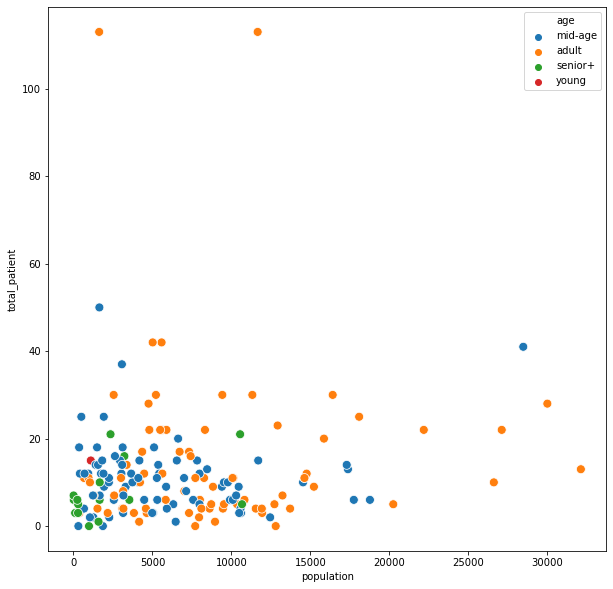

In [41]:
plt.figure(figsize=(10,10))
ax = sns.scatterplot(x="population", y="total_patient", hue='age', s=80,
                     data=sydney_merged[sydney_merged['Cluster Labels'] == 3])
plt.savefig("P-P-A_cluster3.png")

#By visually checking the scatter plot, I found out that the distribution of COVID-19 patients in cluster 3 is characterized by various suburbs and low frequencies. Moreover, the graph suggest that the number of patients in suburbs seems to be divided by 30 or 40. Therefore, the area where more than 30 patients appear in the suburb is regarded as vital area. 

In [44]:
vital_suburb = sydney_merged[(sydney_merged['Cluster Labels'] == 3) &(sydney_merged['total_patient'] > 30)]
vital_suburb

,suburb,postcode,lat,lon,total_patient,population,age,AM,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
69,BONDI BEACH,2026,-33.890542,151.274856,113,11659,adult,29,3,Café,Italian Restaurant,Australian Restaurant,Bakery,Wine Bar,Restaurant,Pizza Place,Ice Cream Shop,Trail,Beach Bar
243,GIRRAWEEN,2145,-33.799843,150.947276,42,5577,adult,29,3,Playground,Car Wash,Café,Dance Studio,Filipino Restaurant,Event Service,Event Space,Falafel Restaurant,Farm,Farmers Market
361,LLANDILO,2747,-33.708904,150.756773,50,1640,mid-age,49,3,Café,Golf Course,Yoga Studio,Food Stand,Event Service,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
417,MOSMAN,2088,-33.829077,151.244090,41,28470,mid-age,49,3,Café,Bakery,Italian Restaurant,Pub,Grocery Store,Cheese Shop,Clothing Store,Japanese Restaurant,Creperie,Fried Chicken Joint
480,PEMULWUY,2145,-33.821944,150.923752,42,5013,adult,29,3,Gym,Café,Yoga Studio,Egyptian Restaurant,Event Service,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
506,QUEENS PARK,2022,-33.903188,151.247205,37,3065,mid-age,49,3,Café,Japanese Restaurant,Yoga Studio,Egyptian Restaurant,Event Service,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
590,TAMARAMA,2026,-33.897439,151.271839,113,1627,adult,29,3,Café,Italian Restaurant,Australian Restaurant,Beach,Scenic Lookout,Restaurant,Beach Bar,Bakery,Tapas Restaurant,Pub


#I narrow down the range of research from cluster 3 to only 7 vital suburbs. I'm going to check the composition of restaurants in these 7 suburbs. 

In [46]:
SGS = sydney_onehot.groupby('Suburb').sum().reset_index()
restaurant = SGS.loc[SGS['Suburb'].isin(list(vital_suburb['suburb'].str.upper()))]
#focus on restaurant
restaurant = restaurant.loc[:, restaurant.columns.str.contains('Restaurant')]
restaurant['suburb'] = SGS['Suburb']

In [47]:
#change the order of columns to get better view
fixed_columns = [restaurant.columns[-1]] + list(restaurant.columns[:-1])
restaurant = restaurant[fixed_columns]
restaurant

,suburb,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,Beijing Restaurant,...,Sushi Restaurant,Syrian Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
63,BONDI BEACH,0,0,0,0,0,0,3,0,0,...,0,0,0,0,0,1,0,0,1,0
215,GIRRAWEEN,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
314,LLANDILO,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
360,MOSMAN,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
415,PEMULWUY,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
439,QUEENS PARK,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
510,TAMARAMA,0,0,1,0,0,0,2,0,0,...,0,0,0,0,1,0,0,0,1,0


In [48]:
#Find the top 10 common types of restauarant within these vital suburbs
for index in list(restaurant.index):
    print("----"+restaurant.loc[index, :][0]+"----")
    print(restaurant.loc[index, :][1:].sort_values(ascending=False).head(10))
    print('\n')

----BONDI BEACH----
Italian Restaurant               3
Australian Restaurant            3
Restaurant                       2
Vegetarian / Vegan Restaurant    1
Thai Restaurant                  1
Middle Eastern Restaurant        1
Vietnamese Restaurant            0
German Restaurant                0
Falafel Restaurant               0
Fast Food Restaurant             0
Name: 63, dtype: object


----GIRRAWEEN----
Vietnamese Restaurant      0
Greek Restaurant           0
Egyptian Restaurant        0
Falafel Restaurant         0
Fast Food Restaurant       0
Filipino Restaurant        0
French Restaurant          0
German Restaurant          0
Grilled Meat Restaurant    0
Italian Restaurant         0
Name: 215, dtype: object


----LLANDILO----
Vietnamese Restaurant      0
Greek Restaurant           0
Egyptian Restaurant        0
Falafel Restaurant         0
Fast Food Restaurant       0
Filipino Restaurant        0
French Restaurant          0
German Restaurant          0
Grilled Meat Restaur

In [ ]:
#The result suggest that suburb Girraween, Llandilo, and Pemulwuy have no restaurant. Suburb Mosman and Queens park only have a few. By manually checking the data, I found that the most common venue for these five suburbs are cafe. 

#Conclusion

In [ ]:
#In this project, I obtained the coordinates, demographic data, and the number of patients of COVID-19 from all NSW state government, domain.com, and other network sources. Through the Foursquare API to obtain the restaurant information of each suburb. Through K-means cluster analysis, I screened the collected information. The screening results show that there are a large number of restaurants in Bondi and Tamarama, and there are many COVID-19 patients. The number of restaurants and the population of the region mean that there are more potential promotion goods customers. In these areas, if there are COVID-19 patients higher than those in other areas, it will stimulate merchants to buy more promotion goods related to epidemic prevention after Sydney releases lockdown.

#I hope this project can help everyone who reads this project, let them prepare sterilize goods when going to Bondi and Tamarama for dinner.